# Classification

### Import Packages

In [1]:
!pip install tensorflow_hub
!pip install tensorflow_text

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

p_stemmer = PorterStemmer() # initialize PorterStemmer

# Set seed for RNG
SEED = 12

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 14.2 MB/s 
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 1.7 MB 56.0 MB/s 
     |████████████████████████████████| 5.9 MB 53.5 MB/s 
     |████████████████████████████████| 438 kB 68.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstal

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Fetching from Github

After further manual data-preprocessing, raw dataset is uploaded to Github and retrieved via url link.

In [2]:
# Retrieve dataset via url link
# Github Repo: https://github.com/X-Yang98/CE4045-NLP
overall_url = "https://raw.githubusercontent.com/xiao-yangg/CE4045-NLP/main/combined_dataset.csv"

overall_df = pd.read_csv(overall_url, encoding='latin') # train and test dataset

In [3]:
# Sanity check for any duplicates
overall_df.drop_duplicates(['tweet'], inplace=True)

# Add index column for identification
overall_df['index'] = list(overall_df.index)

Inter-annotator agreement for evaluation dataset.

In [4]:
no_disagreements = len(overall_df[((overall_df['label_1'] != overall_df['label_2']) | 
                                (overall_df['label_2'] != overall_df['label_3']) |
                                (overall_df['label_3'] != overall_df['label_1'])
                               )])

print("Inter-annotator agreement is {}%.".format((len(overall_df) - no_disagreements)/len(overall_df)*100))

Inter-annotator agreement is 89.29166666666667%.


General function to display sentiment and sentence length distribution.

In [5]:
def show_distribution(label, tweets, name):
    plt.figure(figsize=(18,6))

    # Bar graph visualisation of sentiment distribution
    plt.subplot(1,2,1)
    sns.countplot(x=label)
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.title("Sentiments Distribution in " + name + " Dataset")

    # Bar graph visualisation of sentence length distribution
    plt.subplot(1,2,2)
    sns.histplot([len(s) for s in tweets], bins=100)
    plt.xlabel("Sentence Length")
    plt.ylabel("Count")
    plt.title("Sentence Length Distribution in " + name + " Dataset")

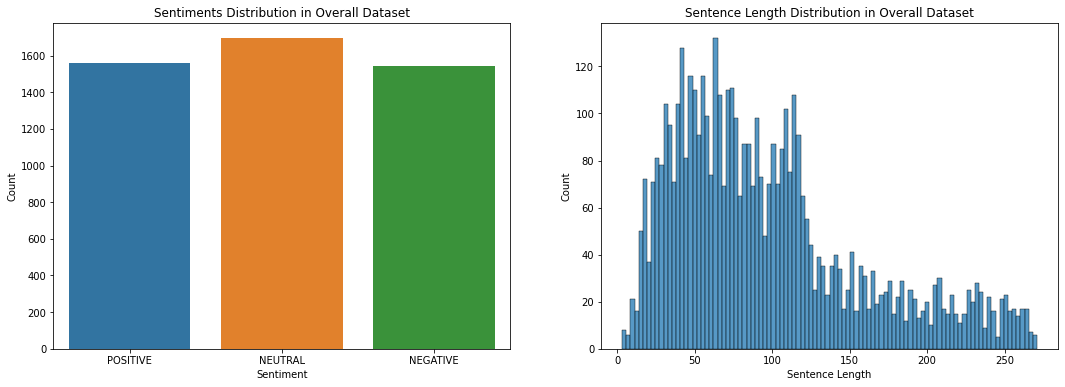

In [6]:
show_distribution(overall_df['final_label'], overall_df['tweet'], "Overall")

### Text Normalization


In [7]:
# Tokenization
def tokenize(text):
    return word_tokenize(text)

# Removal of Stopwords
def remove_stopword(text):
    nltk_tokenList = tokenize(text) # tokenize

    filtered_sentence = [] # sentence without stopwords
    nltk_stop_words = set(stopwords.words("english"))
    for w in nltk_tokenList:  
        if w not in nltk_stop_words:  
            filtered_sentence.append(w)
    
    if len(filtered_sentence) <= 13:
        return text
    return ' '.join(filtered_sentence)

# Stemming
def stemming(token_list):
    stemmed_list = []
    for word in token_list:
        stemmed_list.append(p_stemmer.stem(word))

    return stemmed_list

# Lemmatization
def lemmatization(stemmed_list):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_list = []
    for word in stemmed_list:
        lemma_list.append(wordnet_lemmatizer.lemmatize(word))

    return lemma_list

# Combination of stemming and lemmatization
def nltk_process(text):
    nltk_tokenList = tokenize(text) # tokenize
    nltk_stemmedList = stemming(nltk_tokenList) # stemmed
    nltk_lemmaList = lemmatization(nltk_stemmedList) # lemma

    return ' '.join(nltk_tokenList)

Apply normalization to dataset.

In [8]:
def normalize_df(df):    
    df['no_stopword_tweet'] = df['tweet'].apply(remove_stopword) # obtain tweet without stopwords
    df['normalize_tweet'] = df['no_stopword_tweet'].apply(nltk_process) # tweet with no stopwords go through stemming and lemma

    # New dataframe of text normalized tweets
    columns_titles = ['normalize_tweet','final_label', 'index']
    return df.reindex(columns=columns_titles)

In [9]:
norm_df = normalize_df(overall_df)

### Split into train and test datasets

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(norm_df['normalize_tweet'], # tweet
                                                    norm_df['final_label'], # label
                                                    test_size=0.1, # test size 10% 
                                                    random_state = SEED,
                                                    shuffle=True,
                                                    stratify=norm_df['final_label']) # ensure even proportion of Positive, Negative, Neutral in test data

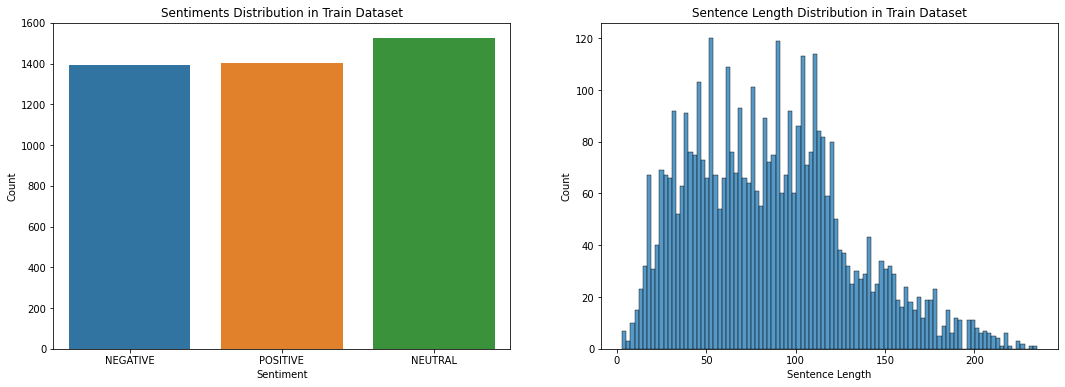

In [11]:
show_distribution(Y_train, X_train, "Train")

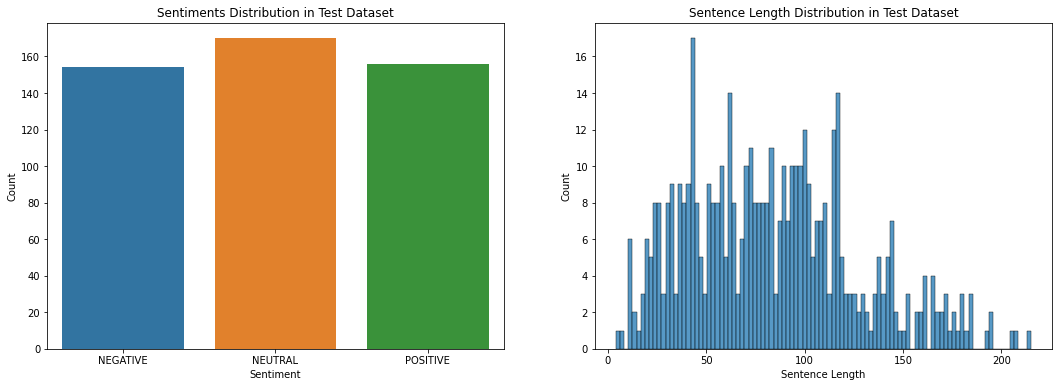

In [12]:
show_distribution(Y_test, X_test, "Test")

### BERT

##### Model Initialization

In [13]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [14]:
# Callbacks
cb = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

In [15]:
def build_BERT():
    
    input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweet')

    preprocess_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocess_layer(input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    x = outputs['pooled_output']
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(x)
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metric = tf.metrics.CategoricalAccuracy('accuracy')
    optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)

    model = tf.keras.Model(input, x)
    model.compile(optimizer=optimizer, loss=loss, metrics=metric)
    return model

In [16]:
model = build_BERT()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tweet (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['tweet[0][0]']                  
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

##### 4-Fold Cross Validation

In [17]:
fold_names = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4']

In [18]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)

X = pd.DataFrame(X_train).reset_index()['normalize_tweet']
Y = pd.DataFrame(Y_train).reset_index()['final_label']

acc = {'Fold 1': {}, 'Fold 2': {}, 'Fold 3': {}, 'Fold 4':{}}
fold = 0
for train_idx, test_idx in cv.split(X, Y):
    print("***** Validating {} *****".format(fold_names[fold]))

    x_train, y_train = X[train_idx], Y[train_idx]
    x_val, y_val = X[test_idx], Y[test_idx]
    
    y_train_c = tf.keras.utils.to_categorical(y_train.astype('category').cat.codes.values, 
                                              num_classes=3)
    y_val_c = tf.keras.utils.to_categorical(y_val.astype('category').cat.codes.values, 
                                             num_classes=3)
    
    history = model.fit(x=x_train,
                        y=y_train_c,
                        validation_data=(x_val, y_val_c),
                        epochs=5,
                        callbacks=cb,
                        verbose=1)
    
    acc[fold_names[fold]]['accuracy'] = history.history['accuracy']
    acc[fold_names[fold]]['val_accuracy'] = history.history['val_accuracy']
    fold += 1

***** Validating Fold 1 *****
Epoch 1/5
102/102 [==============================] - 43s 289ms/step - loss: 0.8756 - accuracy: 0.6062 - val_loss: 0.7433 - val_accuracy: 0.6806
Epoch 2/5
102/102 [==============================] - 24s 239ms/step - loss: 0.6554 - accuracy: 0.7299 - val_loss: 0.6984 - val_accuracy: 0.7056
Epoch 3/5
102/102 [==============================] - 25s 246ms/step - loss: 0.5408 - accuracy: 0.7781 - val_loss: 0.7088 - val_accuracy: 0.7259
Epoch 4/5
102/102 [==============================] - 24s 236ms/step - loss: 0.4537 - accuracy: 0.8256 - val_loss: 0.7352 - val_accuracy: 0.7222
Epoch 5/5
102/102 [==============================] - 25s 244ms/step - loss: 0.4099 - accuracy: 0.8491 - val_loss: 0.7424 - val_accuracy: 0.7204
***** Validating Fold 2 *****
Epoch 1/5
102/102 [==============================] - 24s 238ms/step - loss: 0.4920 - accuracy: 0.8173 - val_loss: 0.2698 - val_accuracy: 0.9139
Epoch 2/5
102/102 [==============================] - 24s 236ms/step - loss: 

##### Visualise Accuracies across K-Folds

In [19]:
colors = ['blue', 'orange', 'green', 'red']

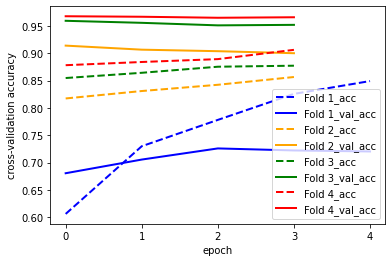

In [20]:
graph_type = ['_acc', '_val_acc']

plt.figure()

for i in range(len(fold_names)):
    plt.plot(acc[fold_names[i]]['accuracy'], marker='', color=colors[i], linewidth=2, 
             linestyle='dashed', label=fold_names[i]+graph_type[0])
    plt.plot(acc[fold_names[i]]['val_accuracy'], marker='', color=colors[i], linewidth=2, 
             label=fold_names[i]+graph_type[1])

plt.xticks([i for i in range(0, 5)])
plt.ylabel('cross-validation accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

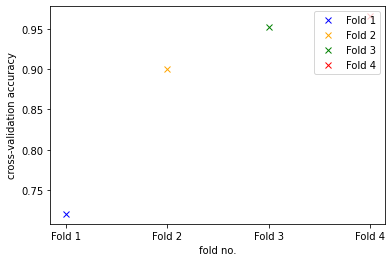

In [21]:
plt.figure()

for i in range(len(fold_names)):
    res = [None, None, None, None]
    res[i] = acc[fold_names[i]]['val_accuracy'][-1]
    
    plt.plot(fold_names, res, marker = 'x', linestyle = 'None', 
             color=colors[i])

plt.xticks(fold_names)
plt.ylabel('cross-validation accuracy')
plt.xlabel('fold no.')
plt.legend([f for f in fold_names], loc='upper right')

##### Model on Test data

In [22]:
y_train_c = tf.keras.utils.to_categorical(Y_train.astype('category').cat.codes.values, 
                                          num_classes=3)
y_test_c = tf.keras.utils.to_categorical(Y_test.astype('category').cat.codes.values, 
                                         num_classes=3)

In [23]:
history = model.fit(x=X_train,
                    y=y_train_c,
                    validation_data=(X_test, y_test_c),
                    epochs=5,
                    callbacks=cb,
                    verbose=1)

Epoch 1/5
135/135 [==============================] - 30s 218ms/step - loss: 0.2565 - accuracy: 0.9104 - val_loss: 0.7821 - val_accuracy: 0.7646
Epoch 2/5
135/135 [==============================] - 29s 217ms/step - loss: 0.2414 - accuracy: 0.9146 - val_loss: 0.7816 - val_accuracy: 0.7542
Epoch 3/5
135/135 [==============================] - 31s 227ms/step - loss: 0.2256 - accuracy: 0.9201 - val_loss: 0.7938 - val_accuracy: 0.7583
Epoch 4/5
135/135 [==============================] - 29s 217ms/step - loss: 0.2244 - accuracy: 0.9178 - val_loss: 0.7981 - val_accuracy: 0.7583


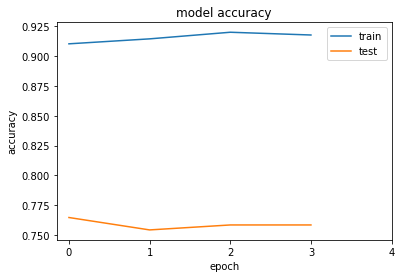

In [24]:
# Summarize history for train and test accuracies
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([i for i in range(0, 5)])
plt.legend(['train', 'test'], loc='upper right')